# DEPENDENCIES FOR BNN USING VI
**Abbreviations**:

- ANN: Artificial Neural Network
- BNN: Bayesian Neural Network
- VI: Variational inference

# Necessary Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# Loading the predefined synthetic regression problems:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module('dependencies_for_data_generation')
from dependencies_for_data_generation import *

importing Jupyter notebook from .\dependencies_for_data_generation.ipynb


# Globally Available Data

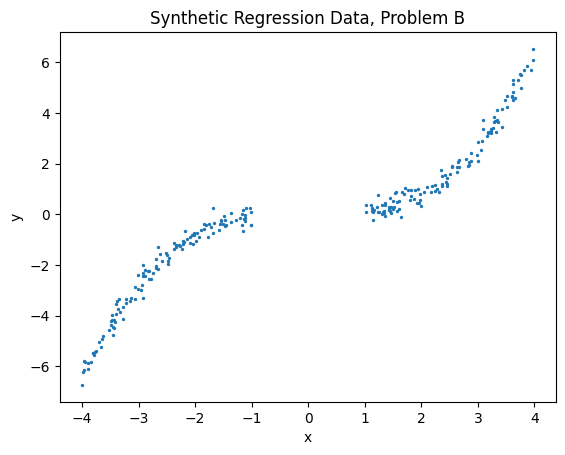

In [2]:
# Initialising data variables by generating a synthetic problem's data:
x_train, y_train, x_test, y_test = None, None, None, None
if __name__ == '__main__':
    x_train, y_train, x_test, y_test = generate_data('B')
else:
    x_train, y_train, x_test, y_test = generate_data('B', visualise_problem=False)

# Defining the Bayesian Model and Loss Functions

In [3]:
class BNN:
    def __init__(self, lr=0.01, prior_mu=0, prior_sigma=1):
        self.model = nn.Sequential(
            bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=1, out_features=100), # Input
            nn.ReLU(),                                                                                    # Non-linear activation
            bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=100, out_features=1)) # Output
    
        #------------------------------------
        # Defining the loss function and optimiser:
        
        # 1. Initialising MSE part of the loss function:
        self.mse_loss = nn.MSELoss()
        
        # 2. Initialising the KL divergence part of the loss function:
        self.kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        self.kl_weight = 0.01 # The weight given to the KL divergence part of the loss function
        
        # 3. Initialising the optimiser used for gradient descent:
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    #================================================
    # WRAPPER FOR THE MODEL'S FORWARD FUNCTION

    def predict(self, x):
        # If data is in NumPy array form, convert to PyTorch tensors:
        if isinstance(x, np.ndarray): x = torch.tensor(x)
        return self.model(x).detach().numpy() # Returning as a NumPy array for convenience
        '''NOTE: Use of `.detach`:
        `.detach` is used because the return value of `self.model(x)` is a tensor that requires grad,
        and such a tensor cannot be converted to a NumPy array using `.numpy`.
        However, using `.detach` creates another tensor with the same values but which does not require grad.
        '''
    
    #================================================
    # TRAINING LOOP

    def fit(self, x_train, y_train, steps=3000):
        # If data is in NumPy array form, convert to PyTorch tensors:
        if isinstance(x_train, np.ndarray): x_train = torch.tensor(x_train)
        if isinstance(y_train, np.ndarray): y_train = torch.tensor(y_train)

        # Training loop:
        for step in range(steps):
            # Obtaining the model's predicted values for the inputs:
            prediction = self.model(x_train)
        
            # Calculating the loss function:
            mse = self.mse_loss(prediction, y_train)
            kl = self.kl_loss(self.model)
            cost = mse + self.kl_weight*kl
        
            # Optimisation step:
            self.optimizer.zero_grad() # Resetting the optimiser's gradients
            cost.backward()       # Calculating the gradients for backpropagation
            self.optimizer.step()      # Applying the gradients for backpropagation
            
        return mse.item(), kl.item()

# Training BNN and Presenting the Results

In [4]:
if __name__ == '__main__':
    bnn_using_vi = BNN()
    mse, kl = bnn_using_vi.fit(x_train, y_train, steps=5000)

Plotting the results (plotting functions packaged as a function for reusability)...

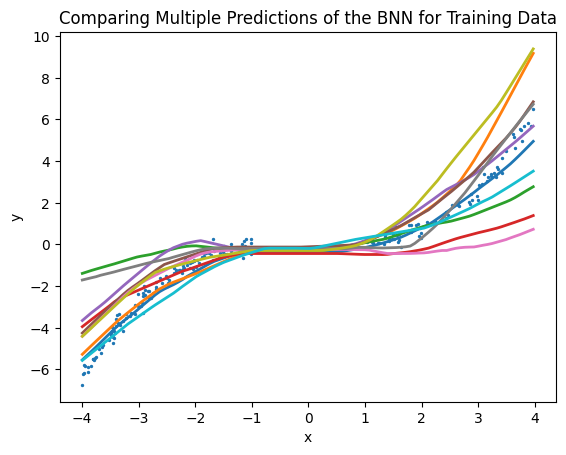

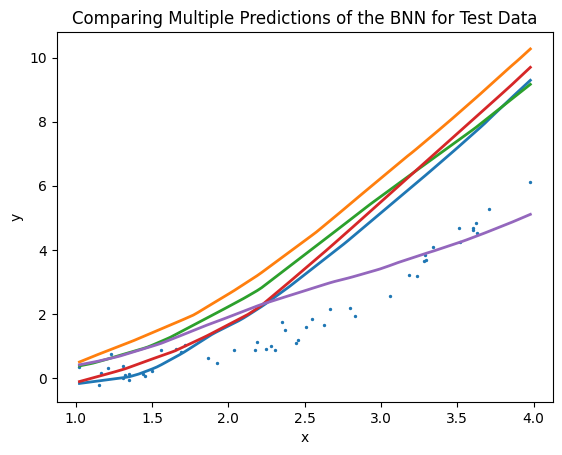

In [5]:
def plot_vi_results(model, samples_to_show=3, show_train_results=True, show_test_results=True, show_labels=True):
    
    # Plotting the training data:
    if show_train_results:
        plt.scatter(x_train, y_train, s=2, label='Train Data') 
        x = np.linspace(min(x_train), max(x_train), 100)
        for i in range(samples_to_show):
            y_predict = bnn_using_vi.predict(x)
            plt.plot(x, y_predict, linewidth=2, label=f'Prediction {i+1}')
        # Final formatting for the plot:
        plt.title('Comparing Multiple Predictions of the BNN for Training Data')
        plt.xlabel('x')
        plt.ylabel('y')
        if show_labels:
            plt.legend()
        plt.show()
        
    # Plotting the test data:
    if show_test_results:
        plt.scatter(x_test, y_test, s=2, label='Test Data') 
        x = np.linspace(min(x_test), max(x_test), 100)
        for i in range(5):
            y_predict = bnn_using_vi.predict(x)
            plt.plot(x, y_predict, linewidth=2, label=f'Prediction {i+1}')
        # Final formatting for the plot:
        plt.title('Comparing Multiple Predictions of the BNN for Test Data')
        plt.xlabel('x')
        plt.ylabel('y')
        if show_labels:
            plt.legend()
        plt.show()

if __name__ == '__main__':
    plot_vi_results(bnn_using_vi, samples_to_show=10, show_labels=False)